In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.features import DivIcon
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline as imb_make_pipeline 
from imblearn.over_sampling import SMOTE

# Match Gas Stations with EV

In [2]:
# load gas station data
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Capstone-KPMG/Preprocessing/Data
!ls
df_gas = pd.read_csv("main_dataset_all_interstate_all_route_10mi_w_income.csv")
df_gas.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Capstone-KPMG/Preprocessing/Data
gas_station_w_dist_to_exit_wholeI5I90I82.csv
main_dataset_all_interstate_all_route_10mi.csv
main_dataset_all_interstate_all_route_10mi_w_income.csv
main_dataset_all_interstate.csv
main_dataset.csv
wa_EV_stations.csv
wa_washington_zip_codes_geo.json


,Unnamed: 0,gas_key,gas_name,gas_lat,gas_long,attr_cnt_1mile,attr_cnt_5mile,attr_name,attr_lat,attr_long,...,nri_zipcode,census_tract_area,census_tract_category,traff_cnt_10m_avg,traff_cnt_10m_max,traff_cnt_5m_avg,traff_cnt_5m_max,zip,zip_income,household_median_income
0,0,0,24 Hour Express Fuel,48.393760,-122.329806,0,1,Skagit County Fairgrounds,48.408145,-122.340118,...,98273.0,0.002191,2.0,21209.859150,72000,23733.802820,72000,98273.0,98273.0,64699
1,1,1,76,47.191712,-120.916225,0,1,KBHR Set,47.223241,-120.993224,...,NaN,0.000584,2.0,11678.727270,36000,9901.025641,34000,98922.0,98922.0,61071
2,2,2,76,47.238704,-122.357577,0,4,Wagon Trail,47.275437,-122.308897,...,98424.0,0.001614,2.0,39766.900000,219000,43117.857140,219000,98424.0,98424.0,78243
3,3,3,76,48.435227,-122.291324,0,1,Skagit County Fairgrounds,48.408145,-122.340118,...,NaN,0.001533,2.0,20470.068490,72000,23101.204820,72000,98273.0,98273.0,64699
4,4,4,76,47.839608,-120.014523,0,0,NaN,NaN,NaN,...,NaN,0.018331,0.0,5653.947368,12000,6723.076923,12000,98817.0,98817.0,71279


In [3]:
df_gas["household_median_income"] = df_gas["household_median_income"].apply(lambda x: np.nan if x == '-' else x)
df_gas["household_median_income"] = pd.to_numeric(df_gas["household_median_income"])
df_gas['household_median_income']= df_gas['household_median_income'].fillna(df_gas['household_median_income'].min())

In [4]:
# load ev station data
%cd /content/drive/My Drive/Capstone-KPMG/Data_Exploration/4_EVChargingStationLocations
!ls

df_ev = pd.read_csv("alt_fuel_stations(Sep_25_2022).csv").query("State == 'WA'")
df_ev.head()

/content/drive/My Drive/Capstone-KPMG/Data_Exploration/4_EVChargingStationLocations
'alt_fuel_stations(Sep_25_2022).csv'


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (20,31,39,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,Status Code,...,EV Pricing (French),LPG Nozzle Types,Hydrogen Pressures,Hydrogen Standards,CNG Fill Type Code,CNG PSI,CNG Vehicle Class,LNG Vehicle Class,EV On-Site Renewable Source,Restricted Access
74,ELEC,City of Lacey - City Hall Parking,420 College St,"At 3rd Ave SE, next to police station",Lacey,WA,98503,NaN,360-491-3214,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
94,ELEC,Avista Corp,1411 E Mission Ave,NaN,Spokane,WA,99252,NaN,509-489-0500,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
95,ELEC,Steam Plant Grill,159 S Lincoln St,NaN,Spokane,WA,99201,NaN,509-777-3900,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
121,ELEC,BELLEVUE BELLEVUE CH 1,450 110th Ave NE,NaN,Bellevue,WA,98004,NaN,888-758-4389,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,ELEC,The Evergreen State College,2700 Evergreen Pkwy NW,Parking Lot C,Olympia,WA,98505,NaN,360-867-6352,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [5]:
# encode lat long
! pip install pygeohash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


https://pypi.org/project/pygeohash/

Setting precision = 6: maximum X axis error of +- 0.61 km (600m) \\
Setting precision = 7: maximum X axis error of +- 0.076 km (76m) \\
Setting precision = 8: maximum X axis error of +- 0.019 km (19m)

In [6]:
import pygeohash as pgh

preci = 8


df_ev['zone'] = df_ev.apply(lambda x: pgh.encode(x['Longitude'], x['Latitude'], precision=preci), axis=1)
df_ev_use = df_ev[['zone','Station Name']]
df_ev_use.columns = ['zone','matched EV']

df_gas['zone'] = df_gas.apply(lambda x: pgh.encode(x['gas_long'], x['gas_lat'], precision=preci), axis=1)

In [7]:
df_use = pd.merge(df_gas, df_ev_use, how="left", left_on="zone", right_on="zone")
df_use[df_use['matched EV'].isna()].shape

(1770, 61)

In [8]:
df_use['matched'] = df_use['matched EV'].notna().astype(int)

In [9]:
df_use['matched'].value_counts()/df_use.shape[0]

0    0.652896
1    0.347104
Name: matched, dtype: float64

In [10]:
df_use.columns

Index(['Unnamed: 0', 'gas_key', 'gas_name', 'gas_lat', 'gas_long',
       'attr_cnt_1mile', 'attr_cnt_5mile', 'attr_name', 'attr_lat',
       'attr_long', 'distance_to_nearest_attr', 'crime_coord', 'crime_county',
       'crime_population', 'violent_crime', 'murder_nonnegligent_manslaughter',
       'Rape1', 'Robbery', 'aggravated_assault', 'property_crime', 'Burglary',
       'larceny_theft', 'motor_vehicle_theft', 'Arson', 'total_crime',
       'exit_name', 'exit_lat', 'exit_long', 'distance_to_nearest_exit',
       'highway', 'num_EV_in_2_miles_of_gas', 'num_EV_in_5_miles_of_gas',
       'num_EV_in_10_miles_of_gas', 'num_EV_in_20_miles_of_gas',
       'num_EV_in_50_miles_of_gas', 'Closest_EV_Station_name',
       'Closest_EV_Station_lat', 'Closest_EV_Station_long',
       'distance_to_closest_ev_station', 'nri_geoid', 'nri_county',
       'nri_population', 'nri_build_value', 'nri_agri_value', 'nri_area',
       'nri_risk_score', 'nri_risk_rating', 'nri_intpt_lat', 'nri_intpt_long',


In [11]:
df_use['total_crime']

0        4903.0
1        1561.0
2       44531.0
3       44531.0
4       44531.0
         ...   
2706    24233.0
2707     4903.0
2708     6542.0
2709     6542.0
2710     6542.0
Name: total_crime, Length: 2711, dtype: float64

In [12]:
df_use[df_use['matched EV'].isna()]

,Unnamed: 0,gas_key,gas_name,gas_lat,gas_long,attr_cnt_1mile,attr_cnt_5mile,attr_name,attr_lat,attr_long,...,traff_cnt_10m_avg,traff_cnt_10m_max,traff_cnt_5m_avg,traff_cnt_5m_max,zip,zip_income,household_median_income,zone,matched EV,matched
0,0,0,24 Hour Express Fuel,48.393760,-122.329806,0,1,Skagit County Fairgrounds,48.408145,-122.340118,...,21209.859150,72000,23733.802820,72000,98273.0,98273.0,64699.0,j042j0p2,NaN,0
1,1,1,76,47.191712,-120.916225,0,1,KBHR Set,47.223241,-120.993224,...,11678.727270,36000,9901.025641,34000,98922.0,98922.0,61071.0,j0181b5b,NaN,0
6,3,3,76,48.435227,-122.291324,0,1,Skagit County Fairgrounds,48.408145,-122.340118,...,20470.068490,72000,23101.204820,72000,98273.0,98273.0,64699.0,j042n0j2,NaN,0
7,4,4,76,47.839608,-120.014523,0,0,NaN,NaN,NaN,...,5653.947368,12000,6723.076923,12000,98817.0,98817.0,71279.0,j0400858,NaN,0
8,5,5,76,47.139542,-122.097343,0,1,Caboose,47.103339,-122.045301,...,27157.016130,104000,15800.000000,44000,98385.0,98385.0,88625.0,j01808jb,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705,2205,2205,NaN,46.900172,-124.106692,0,1,Street of Flags Veterens Memorial,46.871341,-124.103763,...,3738.461538,8500,3460.000000,5800,98595.0,98595.0,53750.0,j01250p8,NaN,0
2706,2206,2206,NaN,48.198460,-122.127847,0,1,Giant Arborvitae (Big Cedar Stump),48.168640,-122.189179,...,26655.473680,123000,26604.166670,102000,98223.0,98223.0,83116.0,j0420b10,NaN,0
2707,2207,2207,NaN,48.556192,-122.344545,0,0,NaN,NaN,NaN,...,19216.976740,72000,17606.250000,49000,98232.0,98232.0,88551.0,j0480bj8,NaN,0
2708,2208,2208,NaN,48.747436,-122.475199,1,1,Mindport Exhibits,48.750881,-122.480674,...,21385.658910,69000,23751.250000,69000,98225.0,98225.0,53093.0,j048j20b,NaN,0


# Modeling: Preprocessing

In [13]:
df_use['census_tract_category'].value_counts()

2.0    1976
1.0     380
0.0     352
Name: census_tract_category, dtype: int64

In [14]:
# drop not useful columns
df_use_cleaned = df_use.drop(['gas_key', 'gas_name', 'gas_lat', 'gas_long',
                              'attr_name', 'attr_lat', 'attr_long',
                              'crime_coord', 'crime_county','total_crime', 'Burglary' ,                       
                              'exit_name', 'exit_lat', 'exit_long', 'distance_to_nearest_exit',
                              'Closest_EV_Station_name', 'Closest_EV_Station_lat', 'Closest_EV_Station_long', 'num_EV_in_2_miles_of_gas',
                              'nri_geoid', 'nri_county', 'nri_zipcode', 'nri_population', 'nri_intpt_lat', 'nri_intpt_long','nri_build_value', 'nri_agri_value', 'nri_area', 'nri_risk_rating',
                              'census_tract_area', 'distance_to_closest_ev_station','attr_cnt_5mile',
                              'num_EV_in_5_miles_of_gas', 'num_EV_in_10_miles_of_gas', 'num_EV_in_20_miles_of_gas', 'num_EV_in_50_miles_of_gas',
                              'traff_cnt_10m_avg', 'traff_cnt_10m_max', 'traff_cnt_5m_avg', 'traff_cnt_5m_max',
                              'zone', 'matched EV','zip','zip_income','Unnamed: 0'], axis = 1)

# 'Burglary', 'Arson'

# fill na
df_use_cleaned['distance_to_nearest_attr'] = df_use_cleaned['distance_to_nearest_attr'].fillna(5)

# for na crime we take min

crime_list = ['violent_crime', 'murder_nonnegligent_manslaughter','Robbery', 'Rape1','aggravated_assault', 'property_crime', 'larceny_theft', 'motor_vehicle_theft','Arson']

df_use_cleaned[crime_list] = df_use_cleaned[crime_list].apply(lambda x: x/df_use_cleaned['crime_population'], axis = 0)
for i in crime_list:
  df_use_cleaned[i]= df_use_cleaned[i].fillna(df_use_cleaned[i].min())

# for na nri we take average
# nri_list = ['nri_build_value', 'nri_agri_value', 'nri_area', 'nri_risk_score']
# for i in nri_list:
df_use_cleaned['nri_risk_score']= df_use_cleaned['nri_risk_score'].fillna(df_use_cleaned['nri_risk_score'].min())

# # nri
#df_use_cleaned['nri_risk_rating'] = df_use_cleaned['nri_risk_rating'].fillna("Insufficient Data")

# def nri_type(x):
#   if x =='Very Low':
#     return -2
#   elif x == 'Relatively Low':
#     return -1
#   elif x == 'Relatively Moderate' or x == 'Insufficient Data' :
#     return 0
#   elif x == 'Relatively High':
#     return 1 
#   elif x == 'Very High':
#     return 2

# df_use_cleaned['nri_risk_rating'] = df_use_cleaned['nri_risk_rating'].apply(lambda x: nri_type(x))


# census tract

df_use_cleaned["household_median_income"] = df_use_cleaned["household_median_income"].apply(lambda x: np.nan if x == '-' else x)
df_use_cleaned["household_median_income"] = pd.to_numeric(df_use_cleaned["household_median_income"])
df_use_cleaned['household_median_income']= df_use_cleaned['household_median_income'].fillna(df_use_cleaned['household_median_income'].min())



df_use_cleaned['census_tract_category'] = df_use_cleaned['census_tract_category'].fillna(2)
df_use_cleaned['census_tract_city'] = df_use_cleaned['census_tract_category'].apply(lambda x: 0 if x<2 else 1)



# drop additional unuseful columns
df_use_cleaned = df_use_cleaned.drop(['crime_population'], axis = 1)


df_use_cleaned.isna().sum()

attr_cnt_1mile                        0
distance_to_nearest_attr              0
violent_crime                         0
murder_nonnegligent_manslaughter      0
Rape1                                 0
Robbery                               0
aggravated_assault                    0
property_crime                        0
larceny_theft                         0
motor_vehicle_theft                   0
Arson                                 0
highway                             617
nri_risk_score                        0
census_tract_category                 0
household_median_income               0
matched                               0
census_tract_city                     0
dtype: int64

In [15]:
# %cd /content/drive/My Drive/Capstone-KPMG/Preprocessing/Data

# df_use_cleaned.to_csv('cleaned_main_data.csv')

In [16]:
df_use_cleaned.dtypes

attr_cnt_1mile                        int64
distance_to_nearest_attr            float64
violent_crime                       float64
murder_nonnegligent_manslaughter    float64
Rape1                               float64
Robbery                             float64
aggravated_assault                  float64
property_crime                      float64
larceny_theft                       float64
motor_vehicle_theft                 float64
Arson                               float64
highway                              object
nri_risk_score                      float64
census_tract_category               float64
household_median_income             float64
matched                               int64
census_tract_city                     int64
dtype: object

In [17]:
df_train = df_use_cleaned[df_use_cleaned['highway']!='I-5'].drop(['highway','census_tract_category','census_tract_city'], axis = 1)
#df_test = df_use_cleaned[df_use_cleaned['highway'].notna()].drop(['highway','census_tract_category', 'matched'], axis = 1)

%cd /content/drive/My Drive/Capstone-KPMG/Modeling
result_list = pd.read_csv('optimization_result.csv')['gas_key'].to_list()
df_test = df_use_cleaned.iloc[df_use[df_use['gas_key'].isin(result_list)].index.tolist()].drop(['highway','census_tract_category', 'census_tract_city','matched'], axis = 1)

print("train:", df_train.shape)
print("test:", df_test.shape)
print("total:", df_use_cleaned.shape)

/content/drive/My Drive/Capstone-KPMG/Modeling
train: (2711, 14)
test: (25, 13)
total: (2711, 17)


In [18]:
df_train['matched'].value_counts()/len(df_train)

0    0.652896
1    0.347104
Name: matched, dtype: float64

# Remove counter-intuitive points

In [19]:
# # df_train = df_train.drop('census_tract_city',axis=1)
# df_train.columns

In [20]:
# df_train1 = df_train.copy()

# # feature_lst = ['violent_crime', 'murder_nonnegligent_manslaughter','Robbery', 'Rape1','aggravated_assault', 'property_crime', 'larceny_theft', 'motor_vehicle_theft']
# feature_lst = ['violent_crime', 'murder_nonnegligent_manslaughter','Robbery', 'Rape1','aggravated_assault', 'property_crime', 'larceny_theft', 'motor_vehicle_theft','Burglary','Arson']

# dropped_index = []

# dropped_1 = df_train1[df_train1['matched'] == 1]

# dropped_2 = df_train1[df_train1['matched'] != 1]

# for i in feature_lst:

#   dropped_1 = dropped_1[dropped_1[i] > df_train1[i].quantile(.75)]
#   dropped_index += dropped_1.index.to_list()
#   dropped_2 = dropped_2[dropped_2[i] < df_train1[i].quantile(.25)]
#   dropped_index += dropped_2.index.to_list()

# print('original shape:', df_train1.shape)
# print('dropped 1 shape:', len(set(dropped_index)))

In [21]:
# df_train1 = df_train.copy()

# feature_lst_2 = ['household_median_income']

# dropped_idx_2 = []

# dropped_lst_1 = df_train1[df_train1['matched'] == 1]

# dropped_lst_2 = df_train1[df_train1['matched'] != 1]


# for i in feature_lst_2:

#   dropped_1 = dropped_lst_1[dropped_lst_1[i] > df_train1[i].quantile(.90)]
#   dropped_index += dropped_1.index.to_list()
#   # dropped_2 = dropped_lst_2[dropped_lst_2[i] < df_train1[i].quantile(.05)]
#   # dropped_index += dropped_2.index.to_list()

# print('original shape:', df_train1.shape)
# print('dropped 2 shape:', len(set(dropped_index)))

In [22]:
# df_train = df_train.drop(index = set(dropped_index))

# Model: Logistic Regression

<ipython-input-23-d755e94e4a8d>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corr = corr.mask(np.triu(np.ones(corr.shape)).astype(np.bool))


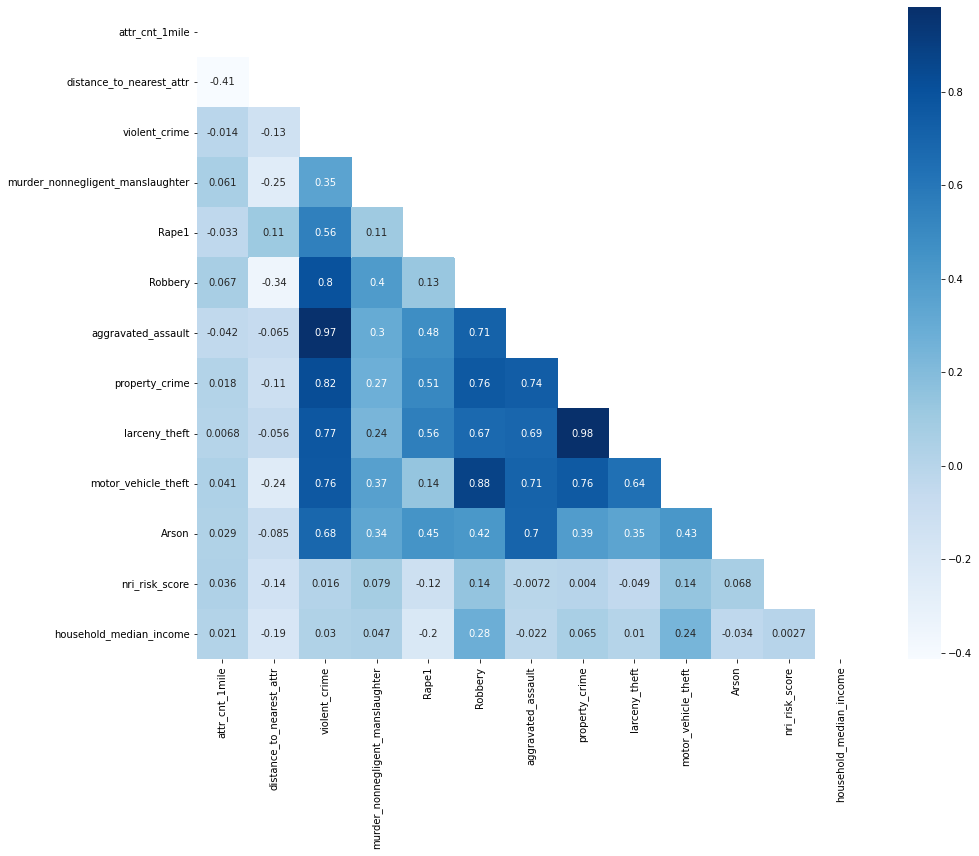

violent_crime
Robbery
property_crime


In [23]:
corr = df_train.drop("matched", axis =1).corr()
corr = corr.mask(np.triu(np.ones(corr.shape)).astype(np.bool))
#corr.style.background_gradient(cmap='coolwarm')
plt.figure(figsize=(15,12))
sns.heatmap(corr,annot = True, cmap="Blues")
plt.show()

df_train1 = df_train.copy()
df_test1 = df_test.copy()

# remove highly correlated features
#np.fill_diagonal(corr.values, -2)
for col in corr.columns:
    if np.sum(corr[col]>0.80) > 0:
      print(col)
      df_train1 = df_train1.drop(col, axis =1)
      df_test1 = df_test1.drop(col, axis =1)

In [24]:
df_X = df_train1.drop(columns=['matched'])
df_y = df_train1['matched']
X_dev, X_test, y_dev, y_test = train_test_split(df_X, df_y , test_size=0.2, stratify=df_train[['matched']])

In [25]:
ss = StandardScaler()
X_dev_std = ss.fit_transform(X_dev)
X_test_std = ss.transform(X_test)
print("Shape of development features:", X_dev_std.shape) 
print("Shape of test features:", X_test_std.shape)

Shape of development features: (2168, 10)
Shape of test features: (543, 10)


In [26]:
smote = SMOTE()
X_dev_smote, y_dev_smote= smote.fit_resample(X_dev_std, y_dev) 
print("Shape of SMOTE development feature:", X_dev_smote.shape) 
y_dev_smote.value_counts()

Shape of SMOTE development feature: (2830, 10)


0    1415
1    1415
Name: matched, dtype: int64

In [27]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_validate

scores = cross_validate(LogisticRegression(solver='liblinear', fit_intercept = False), X_dev_smote, y_dev_smote,
                        cv = 5,
                        scoring = ['roc_auc','average_precision','recall'])

print("Recall:", scores['test_average_precision'].mean())
print("Average Precision:", scores['test_average_precision'].mean())
print("AUC:", scores['test_roc_auc'].mean())

Recall: 0.7448121341297712
Average Precision: 0.7448121341297712
AUC: 0.7558703442420307


In [28]:
lr_smote = LogisticRegression(solver='liblinear', fit_intercept = False).fit(X_dev_smote, y_dev_smote)

In [29]:
y_pred = lr_smote.predict(X_test_std)

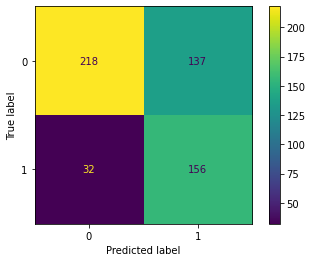

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(
confusion_matrix(y_test, y_pred)).plot()
plt.show()

In [31]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
print('F1 score: ', f1_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print('Accuracy score: ', accuracy_score(y_test, y_pred))

F1 score:  0.6486486486486487
Precision score:  0.5324232081911263
Recall score:  0.8297872340425532
Accuracy score:  0.6887661141804788


In [32]:
len(lr_smote.coef_[0])
#len(X_dev.columns.tolist())

10

In [33]:
feature_importance_lr = zip(lr_smote.coef_[0], X_dev.columns)
feature_importance_lr = sorted(feature_importance_lr, key = lambda x: abs(x[0]), reverse = True)
lr_importance = [i[0] for i in feature_importance_lr]
lr_features = [i[1] for i in feature_importance_lr]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


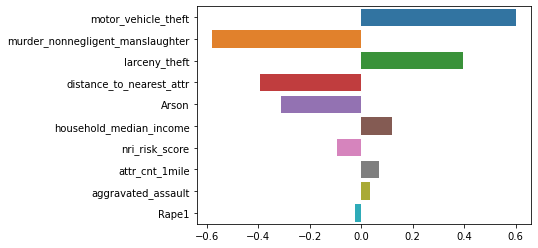

In [34]:
col_names = X_dev.columns.tolist()
#col_names.insert(0,'bias')
sns.barplot(lr_importance, lr_features)
sns.set(font_scale=1.3, rc={'figure.figsize':(6,5)})
#plt.xticks(rotation=90)
plt.show()

In [35]:
# implementation

df_test_lr = df_use.iloc[df_test1.index]
df_test_std = ss.fit_transform(df_test1)

df_test_lr['score'] = np.round(lr_smote.predict_proba(df_test_std)[:,1],2)*100
df_test_lr['score'] = df_test_lr['score'].astype(int)
#np.sum(df_test_lr['matched'] == df_test_lr['predicted'])

<ipython-input-35-f2d5d0ab65c2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_lr['score'] = np.round(lr_smote.predict_proba(df_test_std)[:,1],2)*100
<ipython-input-35-f2d5d0ab65c2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_lr['score'] = df_test_lr['score'].astype(int)


In [36]:
#new_ev = df_test_lr[df_test_lr['matched'] == 0].query("predicted == 1")

In [37]:
center = 46.2735210909813, -122.89553326963093


m = folium.Map(location=center, 
                zoom_start=10,
                width=400,height=950)

# Same as before... go through each home in set, make circle, and add to map.
# This time we add a color using price and the colormap object
for i in range(len(df_test_lr)):
    folium.Circle(
        location=[df_test_lr.iloc[i]['gas_lat'], df_test_lr.iloc[i]['gas_long']],
        radius=1000,
        fill=True,
        color = 'orange',
        fill_opacity=0.2
    ).add_to(m)

# for i in range(len(df_ev)):
#     folium.Circle(
#         location=[df_ev.iloc[i]['Latitude'], df_ev.iloc[i]['Longitude']],
#         radius=1000,
#         fill=True,
#         color = 'blue',
#         fill_opacity=0.2
#     ).add_to(m)

for i in range(len(df_test_lr)):
      folium.map.Marker([df_test_lr.iloc[i]['gas_lat'], df_test_lr.iloc[i]['gas_long']],
                      icon=DivIcon(
                          icon_size=(-10,15),
                          icon_anchor=(-10,14),
                          html=f'<div style="font-size: 14pt">%s</div>' % df_test_lr.iloc[i]['score'],
                      )
                     ).add_to(m)

m

In [38]:

%cd /content/drive/My Drive/Capstone-KPMG/Modeling
result_list = pd.read_csv('optimization_result.csv')['gas_key'].to_list()


/content/drive/My Drive/Capstone-KPMG/Modeling


In [39]:
# 

# Model: Random Forest Classification

In [40]:
df_X = df_train.drop(columns=['matched'])
df_y = df_train['matched']
X_dev, X_test, y_dev, y_test = train_test_split(df_X, df_y , test_size=0.2, stratify=df_train[['matched']])

In [41]:
ss = StandardScaler()
X_dev_std = ss.fit_transform(X_dev)
X_test_std = ss.transform(X_test)
print("Shape of development features:", X_dev_std.shape) 
print("Shape of test features:", X_test_std.shape)

Shape of development features: (2168, 13)
Shape of test features: (543, 13)


In [42]:
smote = SMOTE()
X_dev_smote, y_dev_smote= smote.fit_resample(X_dev_std, y_dev) 
print("Shape of SMOTE development feature:", X_dev_smote.shape) 
y_dev_smote.value_counts()

Shape of SMOTE development feature: (2830, 13)


0    1415
1    1415
Name: matched, dtype: int64

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [5, 10, 50, 100, 150, 200],  
              'max_depth': [1, 5, 10, 50, 100, 150], 
              'max_features':[1.0,'sqrt', 'log2']}  



rf = GridSearchCV(RandomForestClassifier(), 
                        param_grid=params,
                        cv = 5,
                        scoring = ['roc_auc','average_precision','recall'],
                        refit='average_precision')

rf.fit(X_dev_smote, y_dev_smote)
print(rf.best_params_)

{'max_depth': 50, 'max_features': 'log2', 'n_estimators': 150}


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

scores = cross_validate(rf.best_estimator_, X_dev_smote, y_dev_smote,
                        cv = 5,
                        scoring = ['roc_auc','average_precision','recall'])

print("Recall:", scores['test_average_precision'].mean())
print("Average Precision:", scores['test_average_precision'].mean())
print("AUC:", scores['test_roc_auc'].mean())

Recall: 0.9271015354464337
Average Precision: 0.9271015354464337
AUC: 0.9184432319045064


In [45]:
rf_smote = rf.best_estimator_.fit(X_dev_smote, y_dev_smote)

In [46]:
# rf_smote.predict(X_test_std)

In [47]:
y_pred_rf = rf_smote.predict(X_test_std)

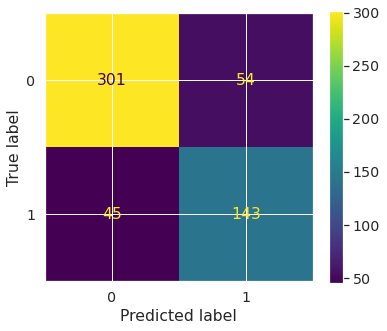

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(
confusion_matrix(y_test, y_pred_rf)).plot()
plt.show()

In [49]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
print('F1 score: ', f1_score(y_test, y_pred_rf))
print('Precision score: ', precision_score(y_test, y_pred_rf))
print('Recall score: ', recall_score(y_test, y_pred_rf))
print('Accuracy score: ', accuracy_score(y_test, y_pred_rf))

F1 score:  0.7428571428571428
Precision score:  0.7258883248730964
Recall score:  0.7606382978723404
Accuracy score:  0.8176795580110497


## Random Forest feature importance

In [50]:
feature_importance = zip(rf_smote.feature_importances_, X_dev.columns)
feature_importance = sorted(feature_importance, key = lambda x: x[0], reverse = True)
rf_importance = [i[0] for i in feature_importance]
rf_features = [i[1] for i in feature_importance]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


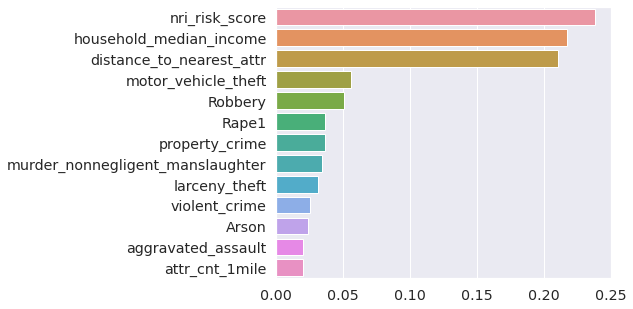

In [51]:
col_names = X_dev.columns.tolist()
sns.barplot(rf_importance, rf_features)
sns.set(font_scale=1.3, rc={'figure.figsize':(6,5)})
plt.show()

In [52]:
# implementation

df_test_rf = df_use.iloc[df_test.index]
df_test_std = ss.fit_transform(df_test)

df_test_rf['score'] = np.round(rf_smote.predict_proba(df_test_std)[:,1],2)*100
df_test_rf['score'] = df_test_rf['score'].astype(int)

<ipython-input-52-048e6e60ae40>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_rf['score'] = np.round(rf_smote.predict_proba(df_test_std)[:,1],2)*100
<ipython-input-52-048e6e60ae40>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_rf['score'] = df_test_rf['score'].astype(int)


In [53]:
center = 46.2735210909813, -122.89553326963093


m = folium.Map(location=center, 
                zoom_start=10,
                width=400,height=950)

# Same as before... go through each home in set, make circle, and add to map.
# This time we add a color using price and the colormap object
for i in range(len(df_test_rf)):
    folium.Circle(
        location=[df_test_rf.iloc[i]['gas_lat'], df_test_rf.iloc[i]['gas_long']],
        radius=1000,
        fill=True,
        color = 'orange',
        fill_opacity=0.2
    ).add_to(m)


for i in range(len(df_test_rf)):
      folium.map.Marker([df_test_rf.iloc[i]['gas_lat'], df_test_rf.iloc[i]['gas_long']],
                      icon=DivIcon(
                          icon_size=(-10,15),
                          icon_anchor=(-10,14),
                          html=f'<div style="font-size: 14pt">%s</div>' % df_test_rf.iloc[i]['score'],
                      )
                     ).add_to(m)

m

# XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [5, 10, 50, 100, 150, 200],  
              'max_depth': [1, 5, 10, 50, 100, 150], 
              'learning_rate':[0.01, 0.1, 1, 1.5, 2, 5]}  



xgb = GridSearchCV(XGBClassifier(), 
                        param_grid=params,
                        cv = 5,
                        scoring = ['roc_auc','average_precision','recall'],
                        refit='average_precision')

xgb.fit(X_dev_smote, y_dev_smote)
print(xgb.best_params_)

{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 50}


In [ ]:

from sklearn.model_selection import cross_validate

scores_xgb = cross_validate(xgb.best_estimator_, X_dev_smote, y_dev_smote,
                                          cv = 5,
                                          scoring = ['roc_auc','average_precision','recall'])

print("Recall:", scores_xgb['test_average_precision'].mean())
print("Average Precision:", scores_xgb['test_average_precision'].mean())
print("AUC:", scores_xgb['test_roc_auc'].mean())

Recall: 0.9702165977092427
Average Precision: 0.9702165977092427
AUC: 0.9709369202226344


In [ ]:
xgb_smote = xgb.best_estimator_.fit(X_dev_smote, y_dev_smote)

In [ ]:
y_pred_xg = xgb_smote.predict(X_test_std)

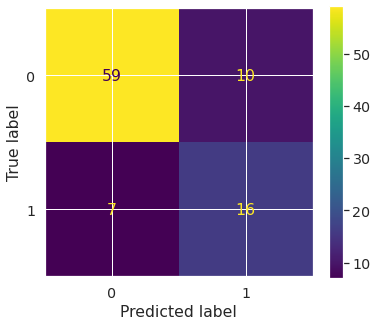

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(
confusion_matrix(y_test, y_pred_xg)).plot()
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
print('F1 score: ', f1_score(y_test, y_pred_xg))
print('Precision score: ', precision_score(y_test, y_pred_xg))
print('Recall score: ', recall_score(y_test, y_pred_xg))
print('Accuracy score: ', accuracy_score(y_test, y_pred_xg))

F1 score:  0.6530612244897959
Precision score:  0.6153846153846154
Recall score:  0.6956521739130435
Accuracy score:  0.8152173913043478


In [ ]:
feature_importance_xgb = zip(xgb_smote.feature_importances_, X_dev.columns)
feature_importance_xgb = sorted(feature_importance_xgb, key = lambda x: x[0], reverse = True)
xgb_importance = [i[0] for i in feature_importance_xgb]
xgb_features = [i[1] for i in feature_importance_xgb]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


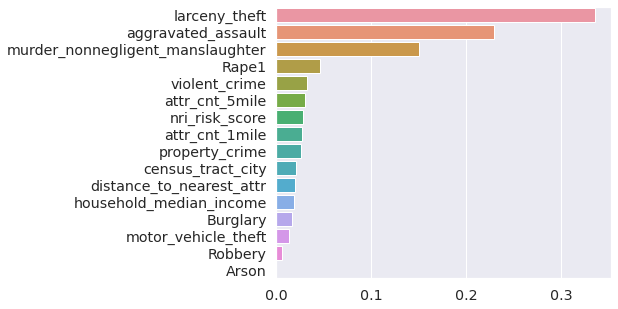

In [ ]:
col_names = X_dev.columns.tolist()

sns.barplot(xgb_importance, xgb_features)
sns.set(font_scale=1.3, rc={'figure.figsize':(6,5)})

plt.show()

In [ ]:
# implementation

df_test_xgb = df_use.iloc[df_test.index]
df_test_std = ss.fit_transform(df_test)

df_test_xgb['score'] = np.round(xgb_smote.predict_proba(df_test_std)[:,1],2)*100
df_test_xgb['score'] = df_test_xgb['score'].astype(int)

<ipython-input-62-670cb9b170cf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_xgb['score'] = np.round(xgb_smote.predict_proba(df_test_std)[:,1],2)*100
<ipython-input-62-670cb9b170cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_xgb['score'] = df_test_xgb['score'].astype(int)


In [ ]:
center = 46.2735210909813, -122.89553326963093


m = folium.Map(location=center, 
                zoom_start=10,
                width=400,height=950)

# Same as before... go through each home in set, make circle, and add to map.
# This time we add a color using price and the colormap object
for i in range(len(df_test_xgb)):
    folium.Circle(
        location=[df_test_xgb.iloc[i]['gas_lat'], df_test_xgb.iloc[i]['gas_long']],
        radius=1000,
        fill=True,
        color = 'orange',
        fill_opacity=0.2
    ).add_to(m)


for i in range(len(df_test_xgb)):
      folium.map.Marker([df_test_xgb.iloc[i]['gas_lat'], df_test_xgb.iloc[i]['gas_long']],
                      icon=DivIcon(
                          icon_size=(-10,15),
                          icon_anchor=(-10,14),
                          html=f'<div style="font-size: 14pt">%s</div>' % df_test_xgb.iloc[i]['score'],
                      )
                     ).add_to(m)

m

# income map

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Capstone-KPMG/Preprocessing/Data

Mounted at /content/drive/
/content/drive/My Drive/Capstone-KPMG/Preprocessing/Data


In [ ]:
import json
boundary_file = "wa_washington_zip_codes_geo.json"
with open(boundary_file, 'r') as f:
    zip_boundary = json.load(f)

In [ ]:
df_income = df_gas[['zip', 'household_median_income']]
df_income = df_income.dropna()
df_income['zip'] = df_income['zip'].astype(int).astype(str)
df_income['household_median_income'] = df_income['household_median_income'].astype(int)
df_income.isna().sum()

zip                        0
household_median_income    0
dtype: int64

In [ ]:
df_income.head()

,zip,household_median_income
0,98273,64699
1,98922,61071
2,98424,78243
3,98273,64699
4,98817,71279


In [ ]:
# import folium
# from folium.features import DivIcon
# from folium import plugins
# plugins.HeatMap(df_income,radius=15).add_to(m)

In [ ]:


import folium
import numpy as np

# grab the center of our map using our cool function
center = 47.7511, -120.7401

m = folium.Map(location=center, 
               zoom_start=7,
               width=800,height=600)


# Create choropleth map  
folium.Choropleth(
    geo_data=zip_boundary,
    name='choropleth',
    data=df_income,
    columns=['zip', 'household_median_income'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    nan_fill_opacity=0,
    line_opacity=1,
    legend_name='household_median_income'
).add_to(m)
m

m

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
center = 46.2735210909813, -122.89553326963093


m = folium.Map(location=center, 
                zoom_start=10,
                width=800,height=950)

# Same as before... go through each home in set, make circle, and add to map.
# This time we add a color using price and the colormap object
# for i in range(len(df_test_xgb)):
#     folium.Circle(
#         location=[df_test_xgb.iloc[i]['gas_lat'], df_test_xgb.iloc[i]['gas_long']],
#         radius=1000,
#         fill=True,
#         color = 'orange',
#         fill_opacity=0.2
#     ).add_to(m)


# for i in range(len(df_test_xgb)):
#       folium.map.Marker([df_test_xgb.iloc[i]['gas_lat'], df_test_xgb.iloc[i]['gas_long']],
#                       icon=DivIcon(
#                           icon_size=(-10,15),
#                           icon_anchor=(-10,14),
#                           html=f'<div style="font-size: 14pt">%s</div>' % df_test_xgb.iloc[i]['score'],
#                       )
#                      ).add_to(m)

m

In [ ]:
# import folium
# from folium.features import DivIcon
# from folium import plugins

# # traffic = pd.read_csv("Data/wa_traffic_counts.csv")[['Y', 'X', 'AADT']].dropna().values.tolist()

# def plot_result(result, traffic_df=traffic):
#   plot_df = pd.DataFrame({'Latitude': pd.Series(dtype='str'),
#                          'Longitude': pd.Series(dtype='str'),
#                          'type': pd.Series(dtype='str'),
#                          'color': pd.Series(dtype='str'),
#                          'radius': pd.Series(dtype='str'),
#                          'gas_key': pd.Series(dtype='str'),
#                          'charger_count': pd.Series(dtype='str')}
#                    )
#   for i in result.keys():
#     new_df = pd.DataFrame([[main.iloc[i]['gas_lat'], main.iloc[i]['gas_long'], 'Proposed', 'blue', 100, i, int(result[i])]], columns=plot_df.columns)
#     plot_df = pd.concat([plot_df, new_df], ignore_index=True)
  
#   plot_df = plot_df.sort_values(by=['Latitude'])


#   ev_station = pd.read_csv('Data/wa_EV_stations.csv')
#   ev_station = ev_station[['Latitude','Longitude']]
#   ev_station['type'] = 'EV'
#   ev_station['color'] = 'gray'
#   ev_station['radius'] = 50
#   ev_station['gas_key'] = ''
#   ev_station['charger_count'] = ''
#   plot_df = pd.concat([ev_station, plot_df], ignore_index=True)

#   # plot_df = plot_df.sort_values(by=['Latitude'])
#   # print(plot_df)
#   #center = 47.139007936370724, -122.52432954892501
#   center = 46.2735210909813, -122.89553326963093

#   m = folium.Map(location=center, 
#                 zoom_start=9,
#                 width=400,height=850)

#   # Same as before... go through each home in set, make circle, and add to map.
#   # This time we add a color using price and the colormap object
#   for i in range(plot_df.shape[0]):
#       folium.Circle(
#           location=[plot_df.iloc[i]['Latitude'], plot_df.iloc[i]['Longitude']],
#           popup=plot_df.iloc[i]['gas_key'],
#           radius=1500,
#           fill=True,
#           color = plot_df.iloc[i]['color'],
#           fill_opacity=0.2
#       ).add_to(m)

#   for i in range(plot_df.shape[0]):
#     if i%2==0:
#       folium.map.Marker([plot_df.iloc[i]['Latitude'], plot_df.iloc[i]['Longitude']],
#                       icon=DivIcon(
#                           icon_size=(-10,15),
#                           icon_anchor=(-10,14),
#                           html=f'<div style="font-size: 14pt">%s</div>' % plot_df.iloc[i]['charger_count'],
#                       )
#                      ).add_to(m)
#     else:
#       folium.map.Marker([plot_df.iloc[i]['Latitude'], plot_df.iloc[i]['Longitude']],
#                       icon=DivIcon(
#                           icon_size=(-10,15),
#                           icon_anchor=(25,14),
#                           html=f'<div style="font-size: 14pt">%s</div>' % plot_df.iloc[i]['charger_count'],
#                       )
#                      ).add_to(m)

#    # add traffic count heatmap
#   plugins.HeatMap(traffic_df,radius=15).add_to(m)

#   print(max([l[2] for l in traffic_df]))
#   print(min([l[2] for l in traffic_df]))

#   return m